### Setup

In [1]:
import numpy as np
import glob, os
from tqdm.auto import tqdm

In [2]:
# Setting up the cache directory
import os
caches_dir = ["Y:/.cache/", "E:/.cache/"]

# Will set the cache in the first caches dir found in the storage
for cache in caches_dir:
    if os.path.exists(cache):
        os.environ['HF_HOME'] = cache
        print(f"Cache path set on {cache}")
        break
    else:
        print(f"Path does not  exist {cache}")

Cache path set on Y:/.cache/


In [3]:
#path = r"ZERO_SHOT_DATASET.tar"
path = r"Y:\ML\datasets\leaf.tar"
if not os.path.exists(path):
    print(f"Path does not  exist {path}")

In [4]:
import datasets
datasets.enable_progress_bars

# load a custom dataset from local/remote files or folders using the ImageFolder feature
dataset = datasets.load_dataset("imagefolder", data_files=path, split="train").cast_column("image", datasets.Image(decode=False))
dataset

Dataset({
    features: ['image', 'label'],
    num_rows: 581
})

In [5]:
# labels = dataset.features["label"].names
# label2id, id2label = dict(), dict()
# for i, label in enumerate(labels):
#     label2id[label] = i
#     id2label[i] = label

# label2id

{'Balayong': 0,
 'Betis': 1,
 'Dao': 2,
 'Kalios': 3,
 'Mulawin': 4,
 'Narra': 5,
 'Yakal': 6}

In [445]:
# Add more candidate labels here for object identification
# Leaf
# Other = human, animal, etc.
# Unknown =  sometimes shows up, sometimes not

labels = ['Leaf', 'Other', 'Unknown'] 

### Testing

In [299]:
from transformers import pipeline
checkpoint = r"google/owlv2-base-patch16-ensemble"

pipe = pipeline(model=checkpoint, 
                task="zero-shot-object-detection",
                #batch_size=4,
                device=0, # Use the first CUDA available GPU
               )

In [446]:
# Creating the confusion matrix
from PIL import Image

true_labels = ['leaf'] * (len(dataset['image']) - 1)

predicted_labels = []
misclassified_images_path = []
misclassified_labels = []
labels

['Leaf', 'Other', 'Unknown', 'Human']

In [447]:
image = r"C:\Users\MASTER\Pictures\millions must die.jpg"
image = r"Y:\ML\datasets\deepimage\random\000055.png"

In [448]:
start = time.time()
predictions = pipe(image, candidate_labels=labels)
end = time.time()
print("Took %.2f s" % ((end - start)))

Took 5.49 s


In [449]:
predictions

[{'score': 0.21065492928028107,
  'label': 'Human',
  'box': {'xmin': 35, 'ymin': 24, 'xmax': 383, 'ymax': 384}},
 {'score': 0.20252332091331482,
  'label': 'Human',
  'box': {'xmin': 3, 'ymin': 43, 'xmax': 115, 'ymax': 116}}]

In [450]:
if len(predictions) > 0:    
    #predicted_label = result[0]
    print(predictions[0]['label'])
else: # Error on model?
    #predicted_label = 'Unknown'
    predicted_label = 'Error: Unidentified'
    print(predicted_label)

Human


In [451]:
image = Image.open(image).convert('RGB')

In [ ]:
start = time.time()

for i, item in tqdm(enumerate(dataset['image'])):
    image = Image.open(item['path'])
    result = pipe(image, candidate_labels=labels) # set image and labels query
    predicted_label = result[0] if result[0]['label'] == 'leaf'
    predicted_labels.append(predicted_label)
    t
    # Check if the prediction is correct
    if predicted_label != true_labels[i]:
        misclassified_images_path.append(item['path'])
        misclassified_labels.append((predicted_label, true_labels[i])) # Tuples 
print("Took %.2f s" % ((end - start)))

### Visualization

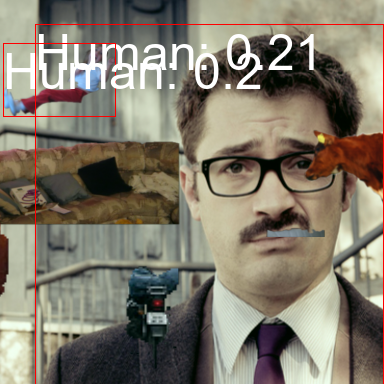

In [452]:
# display the higheest top 3 predictions
from PIL import ImageDraw, Image, ImageFont

# Sort predictions by score in descending order
sorted_predictions = sorted(predictions, key=lambda x: x['score'], reverse=True)

# Get the top 3 predictions
top_3_predictions = sorted_predictions[:3]

draw = ImageDraw.Draw(image)

for prediction in top_3_predictions:
    box = prediction["box"]
    label = prediction["label"]
    score = prediction["score"]
    
    # Define the font and size
    font = ImageFont.truetype('arial.ttf', size=50)
    
    xmin, ymin, xmax, ymax = box.values()
    draw.rectangle((xmin, ymin, xmax, ymax), outline="red", width=1)
    draw.text((xmin, ymin), f"{label}: {round(score, 2)}", fill="white", font=font)

image

#### Display All Predictions

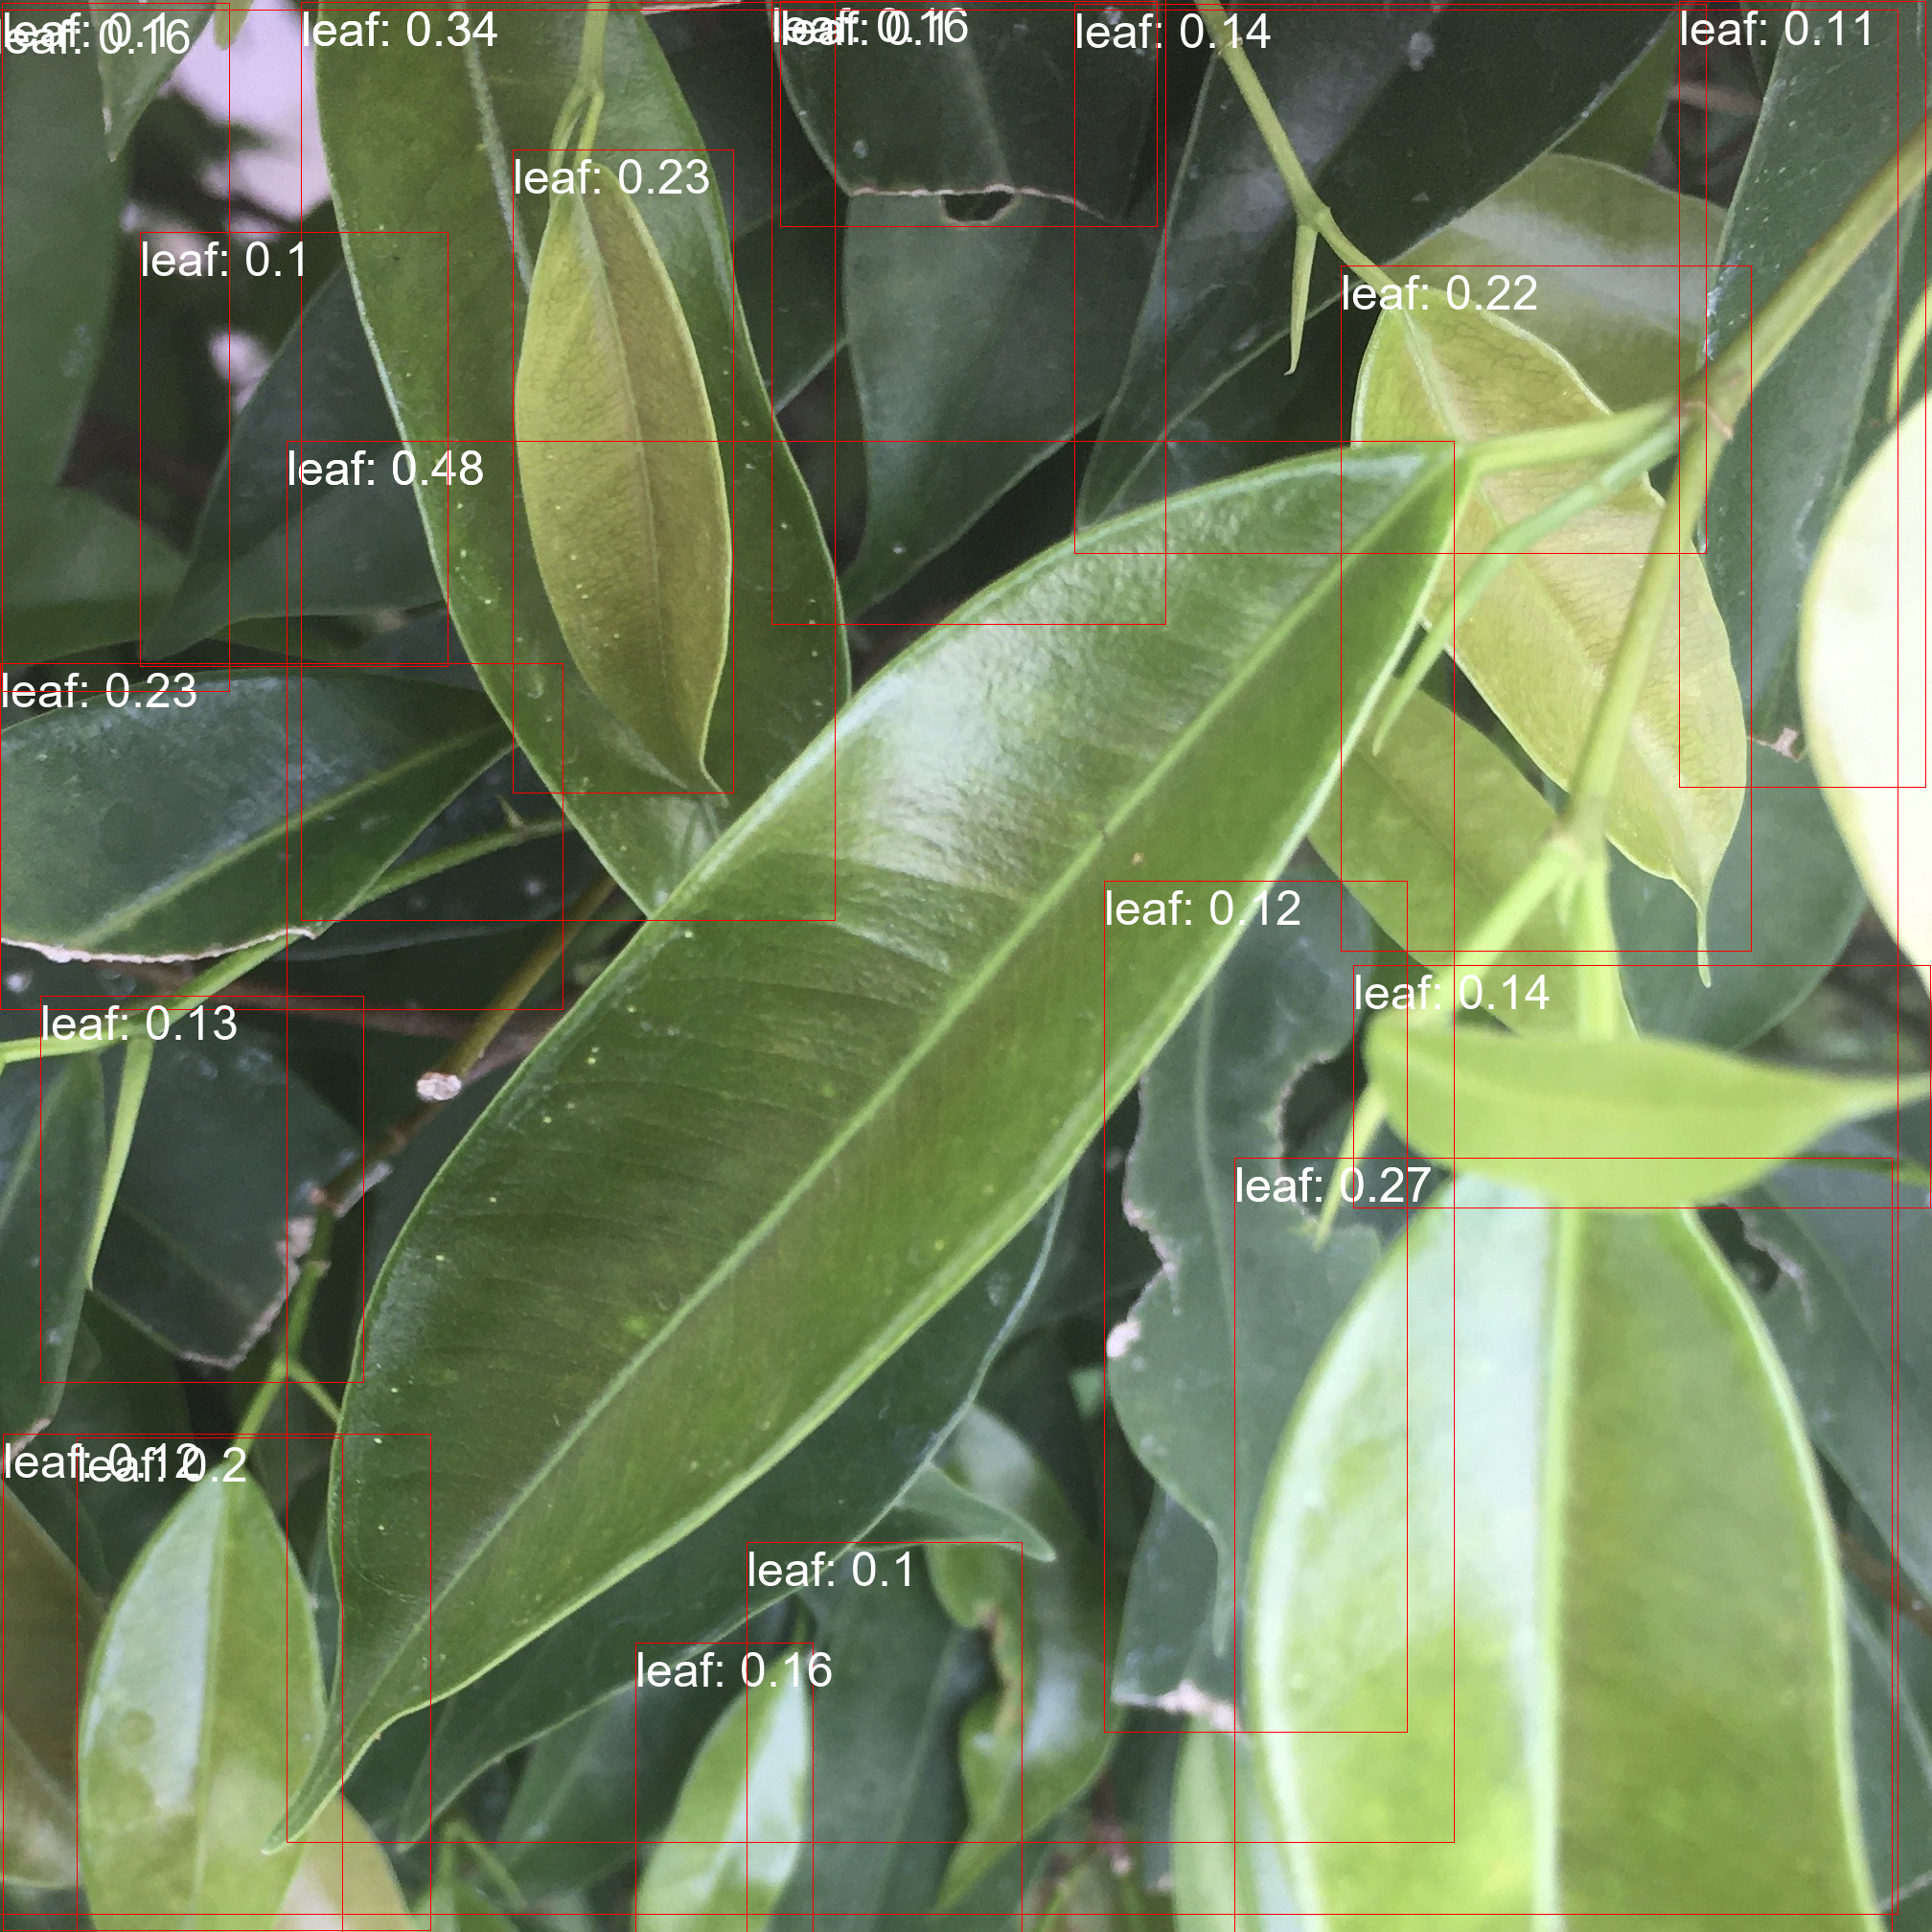

In [322]:

draw = ImageDraw.Draw(image)

for prediction in predictions:
    box = prediction["box"]
    label = prediction["label"]
    score = prediction["score"]
    
    # Define the font and size
    font = ImageFont.truetype('arial.ttf', size=50)
    
    xmin, ymin, xmax, ymax = box.values()
    draw.rectangle((xmin, ymin, xmax, ymax), outline="red", width=1)
    draw.text((xmin, ymin), f"{label}: {round(score,2)}", fill="white", font=font)
    
image

### Data Visualization

In [70]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.utils.class_weight import compute_class_weight

E:\venv\ml\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
E:\venv\ml\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
E:\venv\ml\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


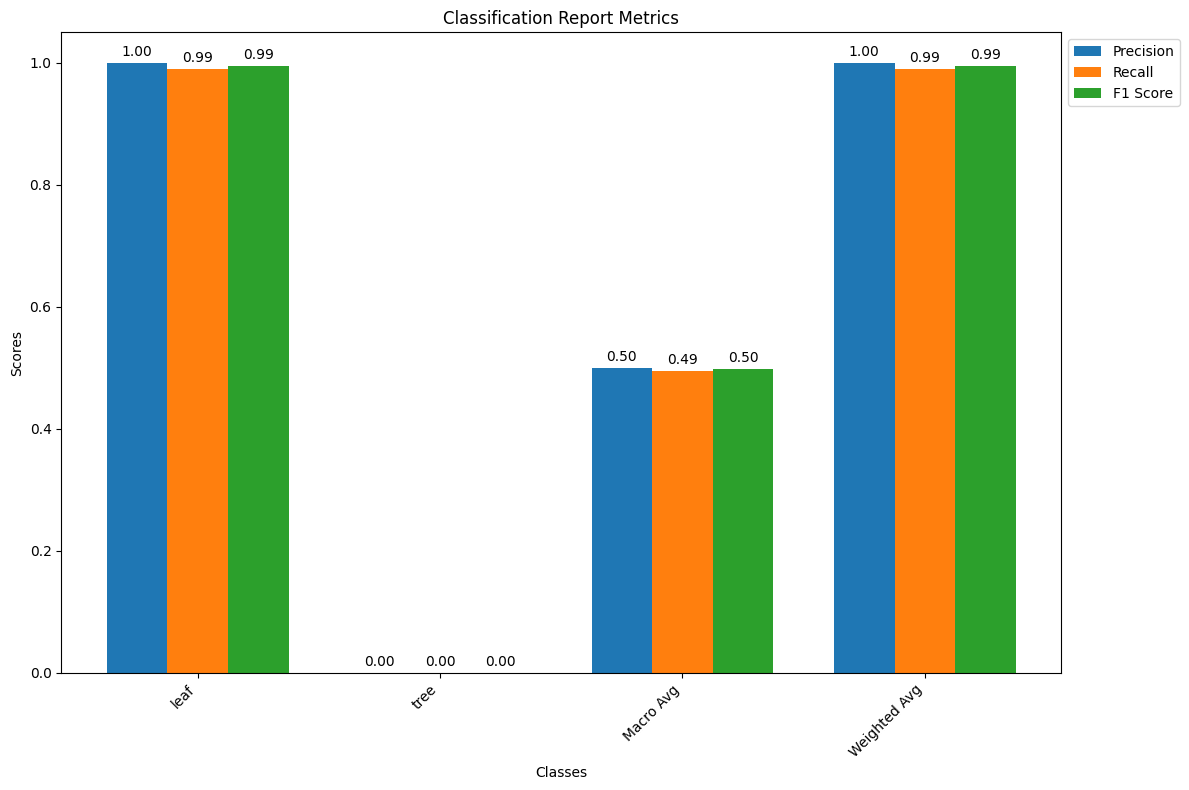

Overall Accuracy: 0.990


In [71]:
# Generate classification report
report = classification_report(true_labels, predicted_labels, output_dict=True)
report_df = pd.DataFrame(report).transpose()

# Extract class-wise metrics
precision = report_df['precision'][:-3]
recall = report_df['recall'][:-3]
f1_score = report_df['f1-score'][:-3]

# Extract overall metrics
accuracy = report_df.loc['accuracy']['f1-score']
macro_avg = report_df.loc['macro avg'][['precision', 'recall', 'f1-score']]
weighted_avg = report_df.loc['weighted avg'][['precision', 'recall', 'f1-score']]

# Plotting
labels = precision.index.tolist() + ['Macro Avg', 'Weighted Avg']
precision = precision.tolist() + [macro_avg['precision'], weighted_avg['precision']]
recall = recall.tolist() + [macro_avg['recall'], weighted_avg['recall']]
f1_score = f1_score.tolist() + [macro_avg['f1-score'], weighted_avg['f1-score']]

x = np.arange(len(labels))  # Label locations
width = 0.25  # Width of the bars

fig, ax = plt.subplots(figsize=(12, 8))

# Create bars
rects1 = ax.bar(x - width, precision, width, label='Precision')
rects2 = ax.bar(x, recall, width, label='Recall')
rects3 = ax.bar(x + width, f1_score, width, label='F1 Score')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Classes')
ax.set_ylabel('Scores')
ax.set_title('Classification Report Metrics')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45, ha='right')

# Place legend outside the plot
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

# Function to add labels to bars
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('%.2f' % height,
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

# Attach labels to bars
autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

fig.tight_layout()
plt.savefig('Classification Report Metrics.png', dpi=300)  # Increase dpi for higher quality
plt.show()

# Print overall accuracy separately
print(f"Overall Accuracy: {accuracy:.3f}")

In [72]:
report

{'leaf': {'precision': 1.0,
  'recall': 0.9896551724137931,
  'f1-score': 0.9948006932409013,
  'support': 580.0},
 'tree': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 0.0},
 'accuracy': 0.9896551724137931,
 'macro avg': {'precision': 0.5,
  'recall': 0.49482758620689654,
  'f1-score': 0.49740034662045063,
  'support': 580.0},
 'weighted avg': {'precision': 1.0,
  'recall': 0.9896551724137931,
  'f1-score': 0.9948006932409013,
  'support': 580.0}}

In [74]:
labels = ['tree', 'leaf', 'unknown']
cm = confusion_matrix(true_labels, predicted_labels, labels=labels)
cm

array([[  0,   0,   0],
       [  6, 574,   0],
       [  0,   0,   0]], dtype=int64)

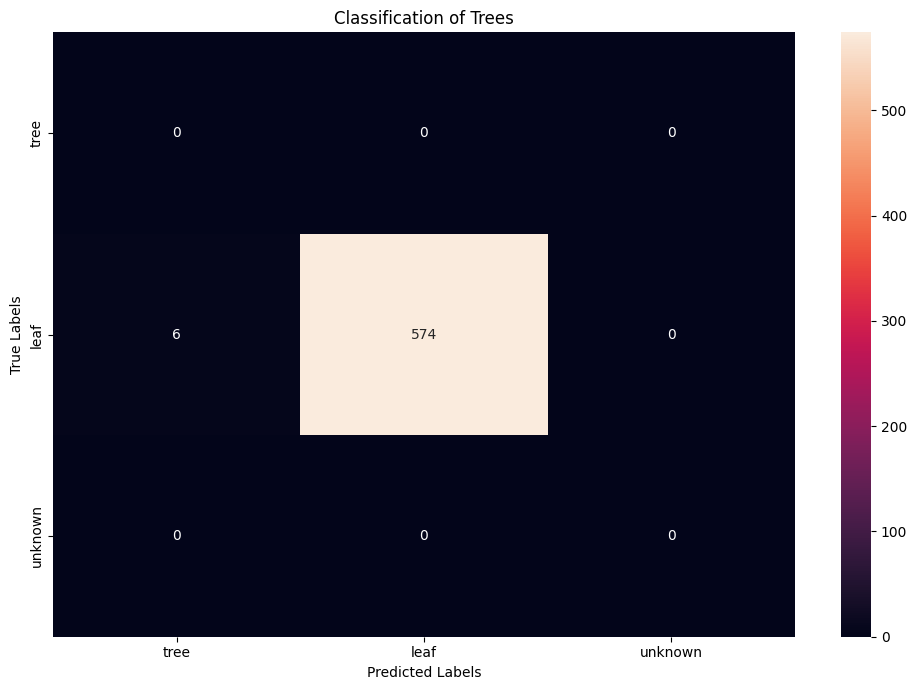

In [75]:
# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Classification of Trees')
plt.tight_layout()
plt.savefig('heatmap.png', dpi=300)  # Increase dpi for higher quality
plt.show()

### Misclassified Images

In [76]:
from collections import defaultdict

# Group the misclassified Images
misclassified_by_class = defaultdict(list)

for path, (pred_label, true_label) in zip(misclassified_images_path, misclassified_labels):
    misclassified_by_class[true_label].append((path, pred_label))

0it [00:00, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

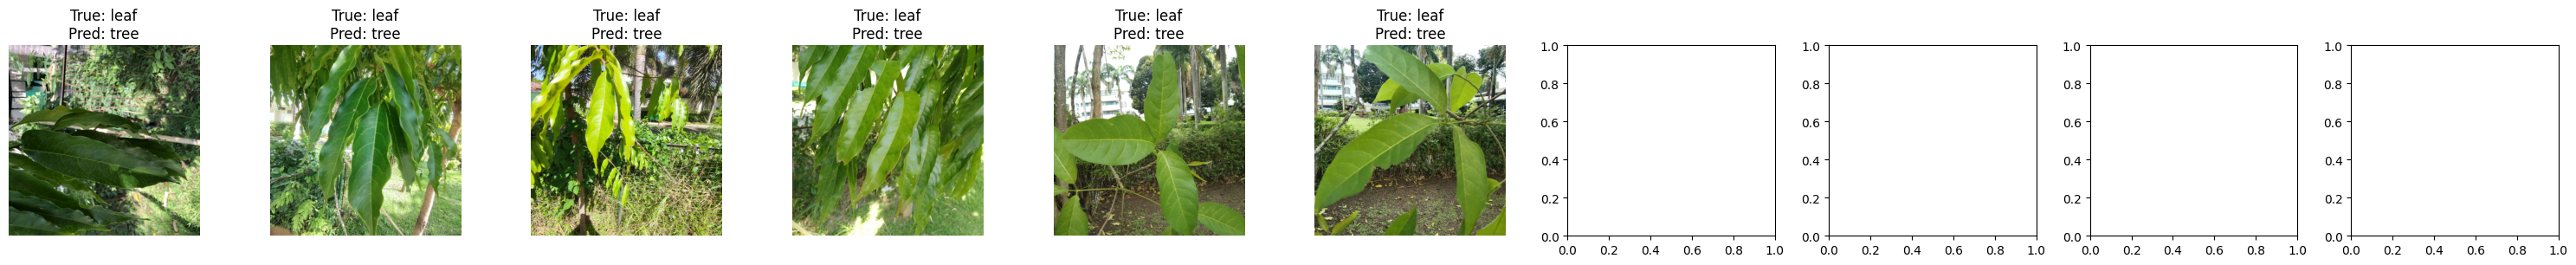

In [77]:
# Display misclassified images
def display_misclassified_images(misclassified_by_class, images_per_class=3):
    classes = list(misclassified_by_class.keys())
    num_classes = len(classes)
    
    fig, axes = plt.subplots(num_classes, images_per_class, figsize=(images_per_class * 3, num_classes * 3))
    
    for i, cls in tqdm(enumerate(classes)):
        misclassified_images = misclassified_by_class[cls]
        for j in tqdm(range(min(images_per_class, len(misclassified_images)))):
            img_path, pred_label = misclassified_images[j]
            image = Image.open(img_path)
            ax = axes[i, j] if num_classes > 1 else axes[j]
            ax.imshow(image)
            ax.set_title(f"True: {cls}\nPred: {pred_label}")
            ax.axis('off')
            
    plt.tight_layout()
    plt.savefig('Misclassifications.png', dpi=300)  # Increase dpi for higher quality
    plt.show()

# Display misclassified images
display_misclassified_images(misclassified_by_class, images_per_class=10)

(-0.5, 3023.5, 3023.5, -0.5)

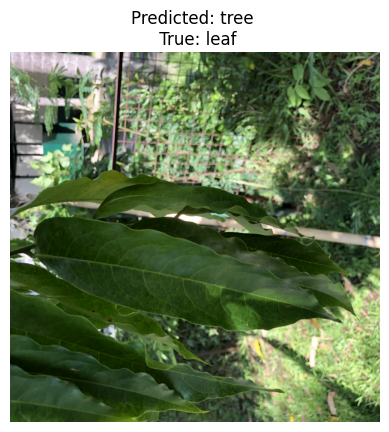

In [80]:
img_path = misclassified_images_path[0]
rlabels = misclassified_labels[0]
image = Image.open(img_path)
pred_label, true_label = rlabels
plt.imshow(image)
plt.title(f"Predicted: {pred_label} \n True: {true_label}")
plt.axis('off')